<a href="https://colab.research.google.com/github/bruaba/mask_detection/blob/main/Projet_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 29 18:40:11 2020

@author: cheikh
"""
#libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random as rand
import keras
import tensorflow_addons as tfa
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from keras_radam import RAdam
from imutils import paths
from bs4 import BeautifulSoup

In [ ]:
def generate_box(obj):  
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    
    return [xmin, ymin, xmax, ymax]

#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 3
    return 0

#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")
#!ls

imgs = list(sorted(os.listdir("MaskTrainDataset/JPEGImages/")))
labels = list(sorted(os.listdir("MaskTrainDataset/Annotations/")))
#nombre d'images et de labels
print(len(imgs))
print(len(labels))

2655
2655


In [ ]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have

i=0
for dirname, _, filenames in os.walk('MaskTrainDataset/Annotations/'):
    for filename in filenames:
        target, numobj = generate_target(i, os.path.join(dirname, filename))
        targets.append(target)
        numobjs.append(numobj)
        i+=1



In [ ]:
i=0
face_images=[]
face_labels=[]


for dirname, _, filenames in os.walk('MaskTrainDataset/JPEGImages/'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        img = cv2.imread(img_path)
        for j in range(numobjs[i]):
            locs = (targets[i]['boxes'][j])
            img1 = img[int(locs[1]):int(locs[3]), int(locs[0]):int(locs[2])]       
            try:
                img1 = cv2.resize(img1, (224, 224))
                img1 = img_to_array(img1)
                img1 = preprocess_input(img1)
                face_images.append(img1)
                face_labels.append(targets[i]['labels'][j])
            except cv2.error:
                continue
            
        i+=1
face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)


In [ ]:

print(len(face_labels))
print(len(face_images))

5773
5773


In [ ]:
import numpy as np
unique, counts = np.unique(face_labels, return_counts=True)
print(dict(zip(unique, counts)))

{1: 4007, 2: 444, 3: 1322}


In [ ]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
# construct the training image generator for data augmentation
"""
La classe ImageDataGenerator garantit que le modèle reçoit de nouvelles variations des images à chaque époque. 
Mais il ne renvoie que les images transformées et ne les ajoute pas au corpus original d'images. 
Si c'était effectivement le cas, alors le modèle verrait les images originales plusieurs fois, ce qui sur-adapterait certainement notre modèle.

Un autre avantage d'ImageDataGenerator est qu'il nécessite une moindre utilisation de la mémoire. 
En effet, sans utiliser cette classe, nous chargeons toutes les images en même temps. Mais en l'utilisant, nous chargeons les images par lots, ce qui économise beaucoup de mémoire.
"""
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:


# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [ ]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
    test_size=0.2, stratify=labels, random_state=42)




In [ ]:
#Free some space.I did this tep as the notebook was running out of space while training
#del targets,face_images,face_labels

In [ ]:
# Définition de l'optimizer (avec quelques paramètres qu'il faudra adapter à ses besoins)
#opt = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=INIT_LR,  name='lr')
# essayer de mettre 10000.0


"""
opt = tfa.optimizers.RectifiedAdam(
    lr=1e-3,
    total_steps=5000,
    warmup_proportion=0.1,
    min_lr=INIT_LR,
)

ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
"""
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)



In [ ]:
# Utilisation de l'optimizer dans un model (déjà configuré avant)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
"""
model.compile(
    optimizer=opt,
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=[tfa.metrics.MultiLabelConfusionMatrix(num_classes=10)])
"""

'\nmodel.compile(\n    optimizer=opt,\n    loss=tfa.losses.TripletSemiHardLoss(),\n    metrics=[tfa.metrics.MultiLabelConfusionMatrix(num_classes=10)])\n'

In [ ]:

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),

	validation_data=(testX, testY),

	epochs=EPOCHS,
	class_weight = {0:5 , 1:1, 2:10})


[INFO] training head...
Epoch 1/50
145/145 [==============================] - 54s 358ms/step - loss: 6.5567 - accuracy: 0.4764 - val_loss: 0.9304 - val_accuracy: 0.5896
Epoch 2/50
145/145 [==============================] - 51s 348ms/step - loss: 5.7787 - accuracy: 0.5217 - val_loss: 0.9595 - val_accuracy: 0.5922
Epoch 3/50
145/145 [==============================] - 50s 346ms/step - loss: 5.4352 - accuracy: 0.5434 - val_loss: 0.9764 - val_accuracy: 0.5879
Epoch 4/50
145/145 [==============================] - 51s 349ms/step - loss: 5.1245 - accuracy: 0.5519 - val_loss: 0.9699 - val_accuracy: 0.6121
Epoch 5/50
145/145 [==============================] - 50s 343ms/step - loss: 5.3447 - accuracy: 0.5346 - val_loss: 0.9712 - val_accuracy: 0.6052
Epoch 6/50
145/145 [==============================] - 50s 348ms/step - loss: 5.0864 - accuracy: 0.5568 - val_loss: 0.9786 - val_accuracy: 0.5948
Epoch 7/50
145/145 [==============================] - 50s 345ms/step - loss: 5.0581 - accuracy: 0.5463 - v

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       802
           1       0.00      0.00      0.00        89
           2       0.19      0.06      0.09       264

    accuracy                           0.65      1155
   macro avg       0.29      0.33      0.29      1155
weighted avg       0.52      0.65      0.57      1155



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


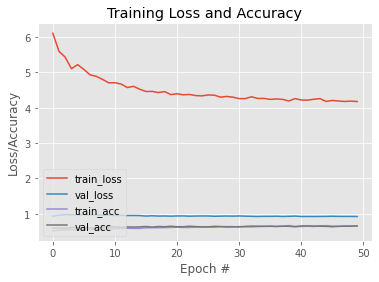

In [ ]:
# plot the training loss and accuracy


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
dt_string = "mask_detector_Adam_" + dt_string
print(dt_string)
model.save(dt_string + ".h5")


[INFO] saving mask detector model...
mask_detector_Adam_2020_12_19_10_26_45


In [ ]:
"""
print('loading model...')
model = tf.keras.models.load_model('mask_detector1.h5')
"""

"\nprint('loading model...')\nmodel = tf.keras.models.load_model('mask_detector1.h5')\n"

In [ ]:
#load the saved model RAdam
"""
print('loading model...')
opt = tfa.optimizers.RectifiedAdam(
    lr=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5, name='Lookahead',)

model = tf.keras.models.load_model('mask_detector_2020_12_19_07_20.h5', custom_objects={'Lookahead': ranger})

print('model loaded')
"""

loading model...


NameError: ignored

In [ ]:
#load the saved model
import keras
model = keras.models.load_model(dt_string + ".h5")

In [ ]:

#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:


# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	epochs=EPOCHS,
    class_weight = {0:5 , 1:1, 2:10})



[INFO] training head...
Epoch 1/50
145/145 [==============================] - 51s 337ms/step - loss: 4.1853 - accuracy: 0.6607 - val_loss: 0.9219 - val_accuracy: 0.6537
Epoch 2/50
145/145 [==============================] - 48s 333ms/step - loss: 4.1421 - accuracy: 0.6646 - val_loss: 0.9249 - val_accuracy: 0.6485
Epoch 3/50
145/145 [==============================] - 48s 329ms/step - loss: 4.1762 - accuracy: 0.6556 - val_loss: 0.9243 - val_accuracy: 0.6459
Epoch 4/50
145/145 [==============================] - 48s 329ms/step - loss: 4.1257 - accuracy: 0.6613 - val_loss: 0.9270 - val_accuracy: 0.6494
Epoch 5/50
145/145 [==============================] - 47s 327ms/step - loss: 4.1770 - accuracy: 0.6535 - val_loss: 0.9270 - val_accuracy: 0.6433
Epoch 6/50
145/145 [==============================] - 48s 328ms/step - loss: 4.1588 - accuracy: 0.6683 - val_loss: 0.9221 - val_accuracy: 0.6459
Epoch 7/50
145/145 [==============================] - 47s 327ms/step - loss: 4.1377 - accuracy: 0.6675 - v

In [ ]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       802
           1       0.00      0.00      0.00        89
           2       0.18      0.08      0.11       264

    accuracy                           0.64      1155
   macro avg       0.29      0.32      0.30      1155
weighted avg       0.52      0.64      0.57      1155



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


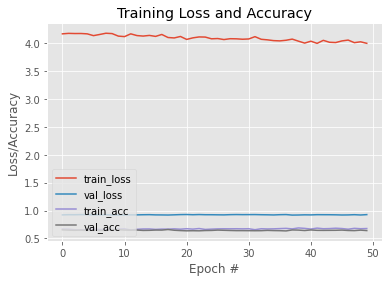

In [ ]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(dt_string + ".png")
plt.show()


In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")

dt_string = dt_string + "_V2"
print(dt_string)
model.save(dt_string+".h5")

[INFO] saving mask detector model...
mask_detector_Adam_2020_12_19_10_26_45_V2
